In [5]:
import os

import torchvision
from os.path import expanduser

from torch.nn.functional import binary_cross_entropy
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import os

datasetsDir = "."
outputDirectory = os.path.join(datasetsDir, "mnistout")
loadSaveFile=False
discriminatorSaveFile=os.path.join(datasetsDir, "save-discriminator-30")
generatorSaveFile=os.path.join(datasetsDir, "save-generator-30")

stddev = [0.5]
mean = [0.5]

stddev = [0.5]
mean = [0.5]

transforms = tt.Compose([
    ToTensor(),
    tt.Normalize(mean=mean, std=stddev)
])

train_ds = torchvision.datasets.MNIST(train=True, download=True, root=datasetsDir, transform=transforms)

batchSize=128

train_dl = DataLoader(train_ds, shuffle=True, batch_size=batchSize, pin_memory=True, drop_last=True)


class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()

        # input: 1x28x28
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1), # 1x14x14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),  # 1x7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),

            nn.Flatten(),
            nn.Linear(64*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


latent_size=64


class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()

        self.prepare = nn.Linear(latent_size, 7*7*32)

        # input: 32 x 7 x 7
        self.network = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=4, padding=1, stride=2, bias=False),  # 4 x 14 x 14
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, kernel_size=4, padding=1, stride=2, bias=False),  # 1 x 28 x 28
            nn.Tanh()
        )

    def forward(self, x):
        out = self.prepare(x)
        reshapedOut = out.reshape(batchSize, 32, 7, 7)
        return self.network(reshapedOut)


def getDefaultDevice():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


device = getDefaultDevice()
print("device=", device)

def toDevice(data, device):
    if isinstance(data, list):
        return [toDevice(d, device) for d in data]
    else:
        return data.to(device)

class DeviceDataLoader:
    def __init__(self, device, dataLoader):
        self.device = device
        self.dataLoader = dataLoader

    def __len__(self):
        return len(self.dataLoader)

    def __iter__(self):
        for d in self.dataLoader:
            yield toDevice(d, self.device)


discriminatorModel = DiscriminatorModel()
generatorModel = GeneratorModel()
discriminatorOptimizer = torch.optim.Adam(discriminatorModel.parameters(), betas=[0.5, 0.9999], lr=0.005)
generatorOptimizer = torch.optim.Adam(generatorModel.parameters(), betas=[0.5, 0.9999], lr=0.005)

discriminatorModel.to(device)
generatorModel.to(device)
train_dl = DeviceDataLoader(device, train_dl)

if loadSaveFile:
    generatorModel.load_state_dict(torch.load(generatorSaveFile, map_location=device))
    discriminatorModel.load_state_dict(torch.load(discriminatorSaveFile, map_location=device))


def trainDiscriminator(x):
    realImagesY = discriminatorModel(x)
    realImagesExpected = torch.ones(batchSize, 1, device=device)
    realLoss = binary_cross_entropy(realImagesY, realImagesExpected)

    fakeImagesGeneratorInput = torch.randn(batchSize, latent_size, device=device)
    fakeImages = generatorModel(fakeImagesGeneratorInput)

    fakeImagesY = discriminatorModel(fakeImages)
    fakeImagesExpected = torch.zeros(len(x), 1, device=device)
    fakeLoss = binary_cross_entropy(fakeImagesY,fakeImagesExpected)

    loss = realLoss + fakeLoss
    loss.backward()
    discriminatorOptimizer.step()

    return loss.item()

def trainGenerator():
    fakeImagesGeneratorInput = torch.randn(batchSize, latent_size, device=device)
    fakeImages = generatorModel(fakeImagesGeneratorInput)

    fakeImagesY = discriminatorModel(fakeImages)
    fakeImagesExpected = torch.ones(batchSize, 1, device=device)
    #print("shape1=", fakeImagesExpected.shape)
    fakeLoss = binary_cross_entropy(fakeImagesY, fakeImagesExpected)
    fakeLoss.backward()

    generatorOptimizer.step()

    return fakeLoss.item()


def denorm(img_tensors):
    return img_tensors * stddev[0] + mean[0]

def save_samples(index, progress=9999):
    fake_images = generatorModel(torch.randn(batchSize, latent_size, device=device))
    fake_fname = 'mnist-generated-images-{0:0=4d}-{1:0=4d}.png'.format(index, progress)
    os.makedirs(outputDirectory, exist_ok=True)
    save_image(denorm(fake_images[:32]).cpu(), os.path.join(outputDirectory, fake_fname), nrow=8)
    print('Saving', fake_fname)

def save_samples_indexed():
    for j in range(latent_size*20):
        random = torch.randn(batchSize, latent_size, device=device)
       # for i in range(batchSize):
       #     random[i][j][0][0] = i * 1.0/batchSize
       #     random[i][30][0][0] = 0.8
       #     random[i][40][0][0] = 0.5
        fake_images = generatorModel(random)
        fake_fname = 'mnist-generated-images-{0:0=4d}-{1:0=4d}.png'.format(j, 0)
        os.makedirs(outputDirectory, exist_ok=True)
        save_image(denorm(fake_images).cpu(), os.path.join(outputDirectory, fake_fname), nrow=8)
        print('Saving', fake_fname)

#save_samples_indexed()
#exit(0)

save_samples(0, 0)


numEpoch=30

for epoch in range(numEpoch):
    generatorModel.train()
    discriminatorModel.train()
    i=0
    for x,y in train_dl:
        generatorModel.zero_grad()
        discriminatorModel.zero_grad()
        discriminatorLoss = trainDiscriminator(x)
        generatorLoss = trainGenerator()
        if i%200 == 0:
            #save_samples(epoch, i)
            print("discriminatorLoss=",discriminatorLoss,"generatorLoss=",generatorLoss)
        i = i + 1
    save_samples(epoch)


torch.save(generatorModel.state_dict(), os.path.join(datasetsDir, "save-generator-" + str(numEpoch)))
torch.save(discriminatorModel.state_dict(), os.path.join(datasetsDir, "save-discriminator-" + str(numEpoch)))

device= cuda
Saving mnist-generated-images-0000-0000.png
discriminatorLoss= 0.5171728730201721 generatorLoss= 7.453953742980957
discriminatorLoss= 0.7464076280593872 generatorLoss= 3.620429754257202
discriminatorLoss= 0.8462738394737244 generatorLoss= 4.3249311447143555
Saving mnist-generated-images-0000-9999.png
discriminatorLoss= 0.5877007246017456 generatorLoss= 2.325885772705078
discriminatorLoss= 0.7952759265899658 generatorLoss= 3.1897804737091064
discriminatorLoss= 0.6941453814506531 generatorLoss= 2.7186315059661865
Saving mnist-generated-images-0001-9999.png
discriminatorLoss= 0.6860913038253784 generatorLoss= 2.611726760864258
discriminatorLoss= 0.8335305452346802 generatorLoss= 2.5186660289764404
discriminatorLoss= 0.48548945784568787 generatorLoss= 2.4766128063201904
Saving mnist-generated-images-0002-9999.png
discriminatorLoss= 0.4037168622016907 generatorLoss= 2.311178684234619
discriminatorLoss= 0.9855026006698608 generatorLoss= 4.567215442657471
discriminatorLoss= 0.537

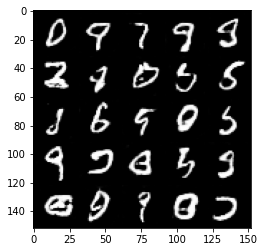

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

fake_images = generatorModel(torch.randn(batchSize, latent_size, device=device))
images = denorm(fake_images[:25]).cpu().detach()

plt.imshow(torchvision.utils.make_grid(images, nrow=5).permute(1,2,0), cmap="gray")
